# Test the Pressure atmospheric transparency Emulator

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS
- creation date : 2023/10/24
- last update : 2023/10/24


This emulator is based from datagrid of atmospheric transparencies extracted from libradtran

In [1]:
import numpy as np
import pandas as pd
import os
from scipy import interpolate
from astropy.io import fits
from astropy.table import Table
import seaborn as sns
import copy

from importlib.resources import files

In [2]:
from atmpressemulator.atmpressemulator import AtmPressEmulator
from simpleemulator.simpleatmemulator import Dict_Of_sitesAltitudes,Dict_Of_sitesPressures

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

# to enlarge the sizes
params = {'legend.fontsize': 'large',
          'figure.figsize': (12, 6),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)


In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
FLAG_CHECKWITHLIBRADTRAN = False

In [6]:
AIRMASSMIN = 1.0
AIRMASSMAX=2.6
DAM = 0.2
airmasses = np.arange(AIRMASSMIN,AIRMASSMAX,DAM)
NAM=len(airmasses)

In [7]:
PWVMIN = 0
PWVMAX = 11
DPWV = 0.5
pwvs = np.arange(PWVMIN,PWVMAX,DPWV)
NPWV = len(pwvs)

In [8]:
pwvs

array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
        5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5])

In [9]:
OZMIN = 0
OZMAX = 600
DOZ   = 50
ozs = np.arange(OZMIN,OZMAX,DOZ)
NOZ = len(ozs)

In [10]:
ozs

array([  0,  50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550])

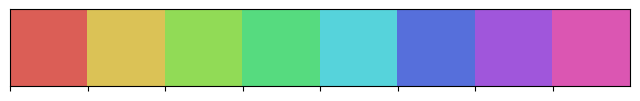

In [11]:
hls_colors = sns.color_palette("hls", NAM)
sns.palplot(hls_colors)

# Check emulator

In [12]:
Dict_Of_sitesPressures

{'LSST': 731.50433,
 'CTIO': 774.6052,
 'OHP': 937.22595,
 'PDM': 710.90637,
 'OMK': 600.17224,
 'OSL': 1013.0}

In [13]:
obs_str = 'LSST'
std_pressure = Dict_Of_sitesPressures[obs_str]
new_pressure = Dict_Of_sitesPressures[obs_str]*1.1
new_pressure

label1 = f"P = {std_pressure:.0f} hPa"
label2 = f"P = {new_pressure:.0f} hPa"

In [14]:
emul1 =  AtmPressEmulator(obs_str=obs_str)
emul2 =  AtmPressEmulator(obs_str=obs_str,pressure = new_pressure)

Observatory LSST found in preselected observation sites
Observatory LSST found in preselected observation sites


In [15]:
WL = emul1.GetWL()

## Check emulator with Rayleigh scattering

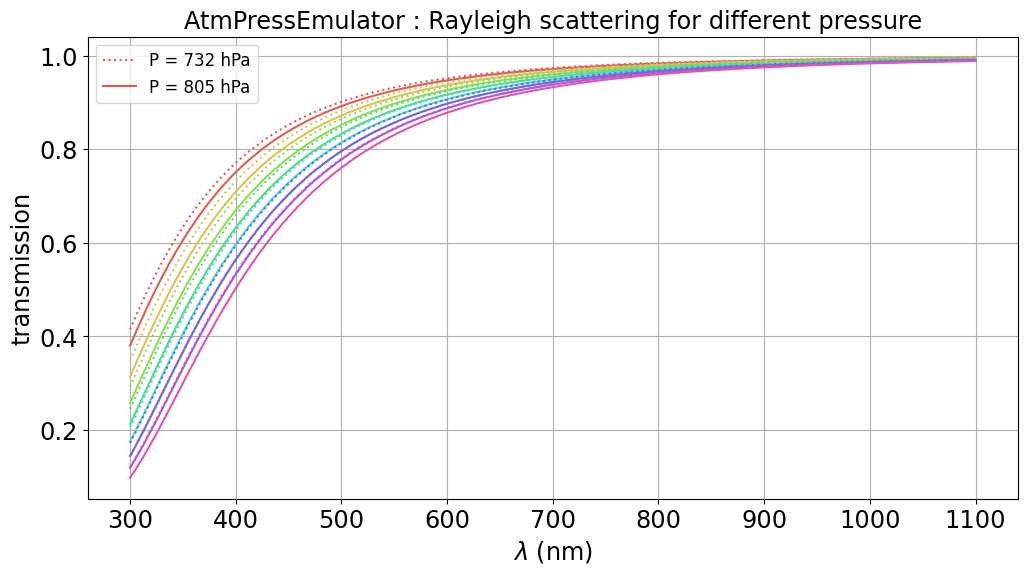

In [16]:
fig, ax = plt.subplots()
for idx,am in enumerate(airmasses):

    transm1 = emul1.GetRayleighTransparencyArray(WL,am)
    transm2 = emul2.GetRayleighTransparencyArray(WL,am)
    
    if idx == 0:
        ax.plot(WL,transm1,":",color=hls_colors[idx],label=label1)
        ax.plot(WL,transm2,"-",color=hls_colors[idx],label=label2)
    else:
        ax.plot(WL,transm1,":",color=hls_colors[idx])
        ax.plot(WL,transm2,"-",color=hls_colors[idx])
    
title = f"AtmPressEmulator : Rayleigh scattering for different pressures"
ax.set_title(title)
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("transmission")
# place a text box in upper left in axes coords
#ax.text(0.5, 0.05, textboxstr, transform=ax.transAxes, fontsize=14,verticalalignment='bottom', bbox=textboxprops)
ax.grid()
ax.legend()


## Check emulator with Oxygen O2 absorption

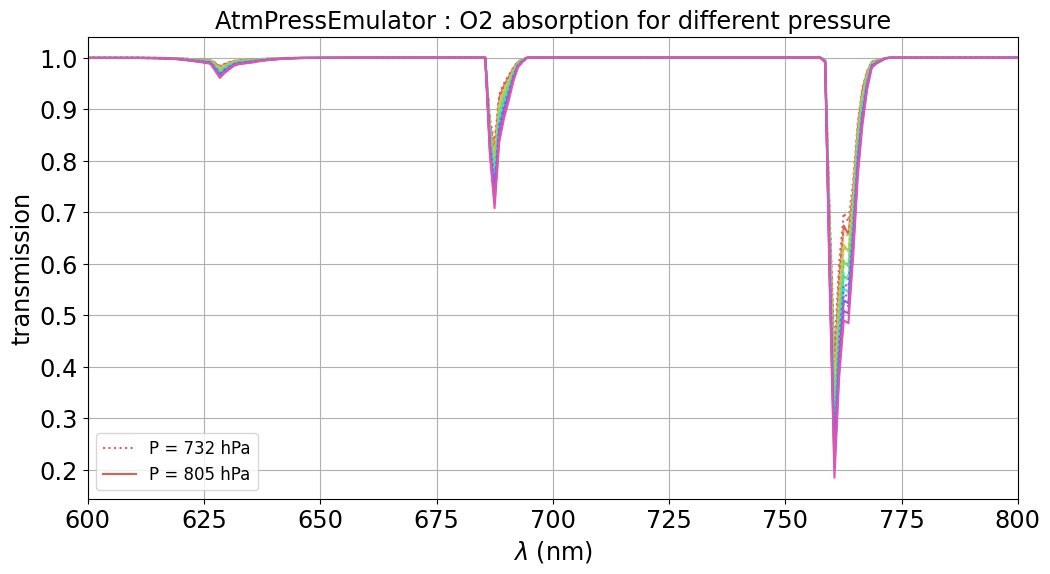

In [17]:
fig, ax = plt.subplots()
for idx,am in enumerate(airmasses):

    transm1 = emul1.GetO2absTransparencyArray(WL,am)
    transm2 = emul2.GetO2absTransparencyArray(WL,am)
    
    if idx == 0:
        ax.plot(WL,transm1,":",color=hls_colors[idx],label=label1)
        ax.plot(WL,transm2,"-",color=hls_colors[idx],label=label2)
    else:
        ax.plot(WL,transm1,":",color=hls_colors[idx])
        ax.plot(WL,transm2,"-",color=hls_colors[idx])
        

title = f"AtmPressEmulator : O2 absorption for different pressures"
ax.set_title(title)
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("transmission")
ax.set_xlim(600.,800.)
# place a text box in upper left in axes coords
#ax.text(0.5, 0.05, textboxstr, transform=ax.transAxes, fontsize=14,verticalalignment='bottom', bbox=textboxprops)
ax.grid()
ax.legend()

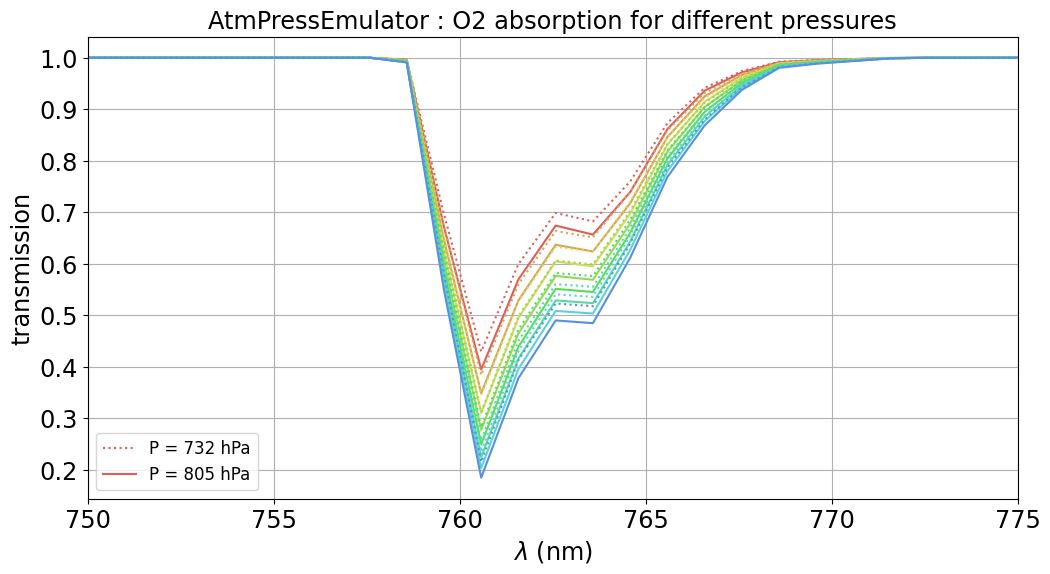

In [25]:
fig, ax = plt.subplots()
for idx,am in enumerate(airmasses):

    transm1 = emul1.GetO2absTransparencyArray(WL,am)
    transm2 = emul2.GetO2absTransparencyArray(WL,am)
    
    if idx == 0:
        ax.plot(WL,transm1,":",color=hls_colors[idx],label=label1)
        ax.plot(WL,transm2,"-",color=hls_colors[idx],label=label2)
    else:
        ax.plot(WL,transm1,":",color=hls_colors[idx])
        ax.plot(WL,transm2,"-",color=hls_colors[idx])
        

title = f"AtmPressEmulator : O2 absorption for different pressures"
ax.set_title(title)
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("transmission")
ax.set_xlim(750.,775.)
# place a text box in upper left in axes coords
#ax.text(0.5, 0.05, textboxstr, transform=ax.transAxes, fontsize=14,verticalalignment='bottom', bbox=textboxprops)
ax.grid()
ax.legend()

## Check emulator with PWV absorption

Expect no difference

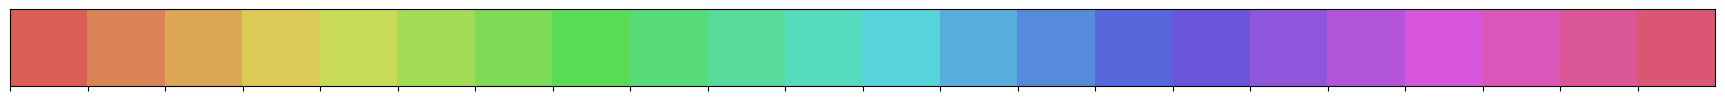

In [18]:
hls_colors = sns.color_palette("hls", NPWV)
sns.palplot(hls_colors)

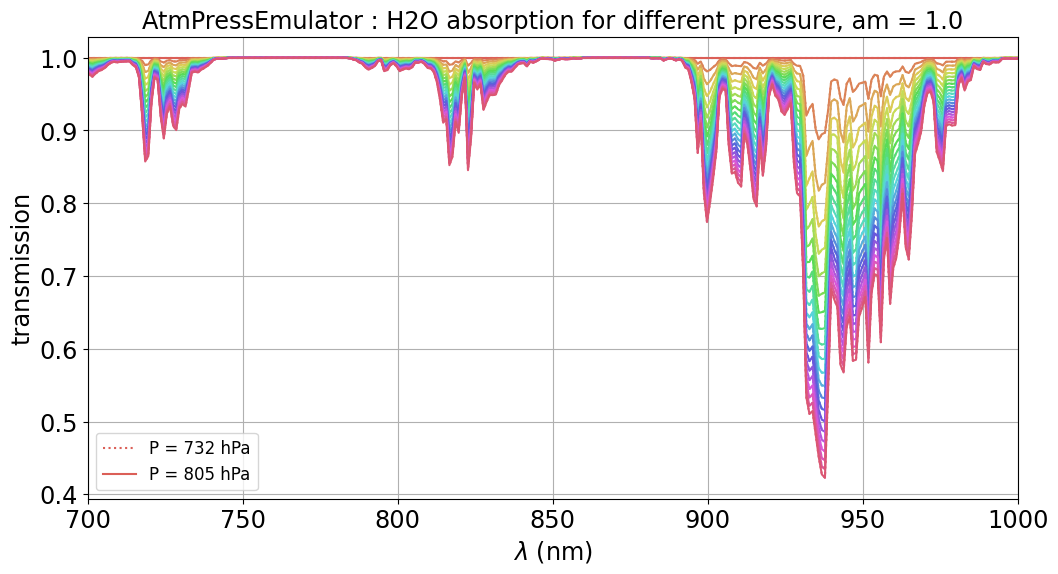

In [19]:
am =1

fig, ax = plt.subplots()
for idx,pwv in enumerate(pwvs):

    transm1 = emul1.GetPWVabsTransparencyArray(WL,am,pwv)
    transm2 = emul2.GetPWVabsTransparencyArray(WL,am,pwv)
    
    if idx == 0:
        ax.plot(WL,transm1,":",color=hls_colors[idx],label=label1)
        ax.plot(WL,transm2,"-",color=hls_colors[idx],label=label2)
    else:
        ax.plot(WL,transm1,":",color=hls_colors[idx])
        ax.plot(WL,transm2,"-",color=hls_colors[idx])
        

title = f"AtmPressEmulator : H2O absorption for different pressures, am = {am:.1f}"
ax.set_title(title)
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("transmission")
ax.set_xlim(700.,1000.)
# place a text box in upper left in axes coords
#ax.text(0.5, 0.05, textboxstr, transform=ax.transAxes, fontsize=14,verticalalignment='bottom', bbox=textboxprops)
ax.grid()
ax.legend()



## Check emulator with Ozone absorption

- expect no difference

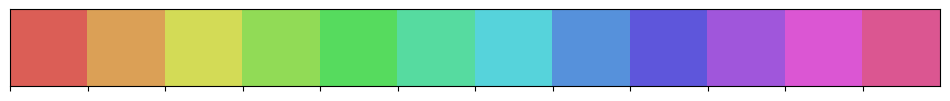

In [20]:
hls_colors = sns.color_palette("hls", NOZ)
sns.palplot(hls_colors)

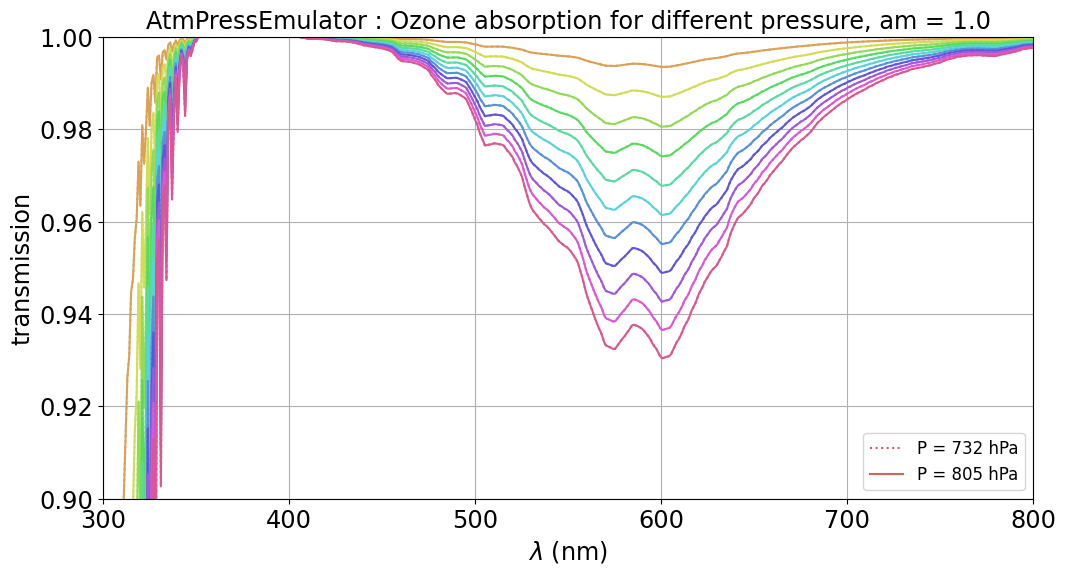

In [21]:
am =1

fig, ax = plt.subplots()
for idx,oz in enumerate(ozs):

    transm1 = emul1.GetOZabsTransparencyArray(WL,am,oz)
    transm2 = emul2.GetOZabsTransparencyArray(WL,am,oz)
    
    if idx == 0:
        ax.plot(WL,transm1,":",color=hls_colors[idx],label=label1)
        ax.plot(WL,transm2,"-",color=hls_colors[idx],label=label2)
    else:
        ax.plot(WL,transm1,":",color=hls_colors[idx])
        ax.plot(WL,transm2,"-",color=hls_colors[idx])
        

title = f"AtmPressEmulator : Ozone absorption for different pressure, am = {am:.1f}"
ax.set_title(title)
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("transmission")
ax.set_xlim(300.,800.)
ax.set_ylim(0.9,1.0)
# place a text box in upper left in axes coords
#ax.text(0.5, 0.05, textboxstr, transform=ax.transAxes, fontsize=14,verticalalignment='bottom', bbox=textboxprops)
ax.grid()
ax.legend()



## Check emulator with combined ascattering and absorption process and check with libradtran

In [22]:
am0 = 1.0
pwv0 = 5.0
oz0 = 500.
transm1 = emul1.GetGriddedTransparencies(WL,am0,pwv0,oz0,flagRayleigh=True)
transm2 = emul2.GetGriddedTransparencies(WL,am0,pwv0,oz0,flagRayleigh=True)

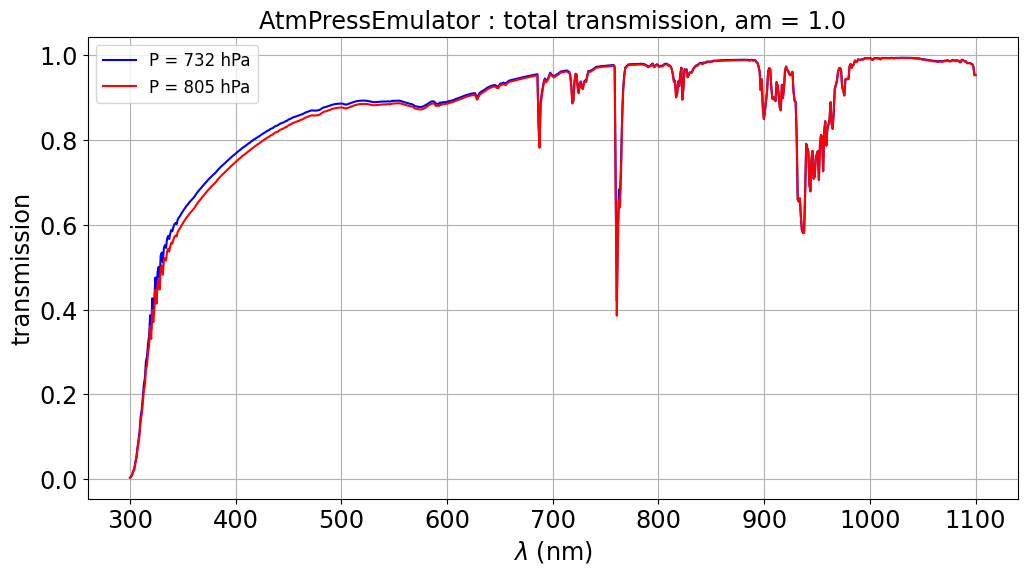

In [23]:
fig, ax = plt.subplots()

ax.plot(WL,transm1,'b-',label=label1)
ax.plot(WL,transm2,'r-',label=label2)

title = f"AtmPressEmulator : total transmission, am = {am0:.1f}"
ax.set_title(title)
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("transmission")
# place a text box in upper left in axes coords
#ax.text(0.5, 0.05, textboxstr, transform=ax.transAxes, fontsize=14,verticalalignment='bottom', bbox=textboxprops)
ax.grid()
ax.legend()

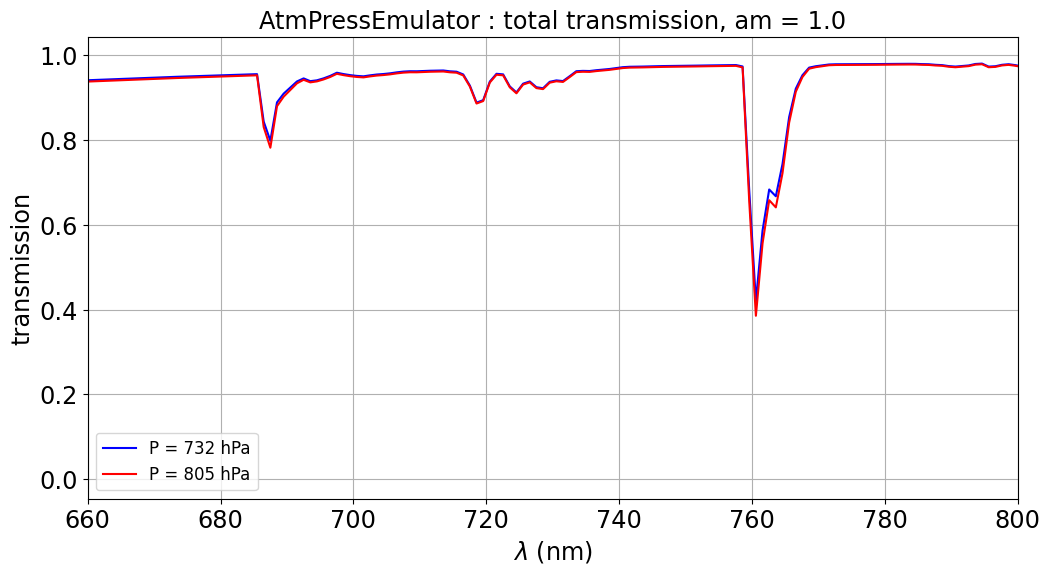

In [24]:
fig, ax = plt.subplots()

ax.plot(WL,transm1,'b-',label=label1)
ax.plot(WL,transm2,'r-',label=label2)

title = f"AtmPressEmulator : total transmission, am = {am0:.1f}"
ax.set_title(title)
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("transmission")
ax.set_xlim(660.,800.)
# place a text box in upper left in axes coords
#ax.text(0.5, 0.05, textboxstr, transform=ax.transAxes, fontsize=14,verticalalignment='bottom', bbox=textboxprops)
ax.grid()
ax.legend()